In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import numpy as np
import pandas as pd

In [5]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [58]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'r2', 'n_iter']] = cv_results[[
        'param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_r2', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [59]:
from sklearn.datasets import make_regression
from optiml.ml.utils import generate_nonlinearly_regression_data

lin_X, lin_y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)
nonlin_X, nonlin_y = generate_nonlinearly_regression_data()

## Epsilon-insensitive loss

### Primal formulation

In [60]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [61]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits


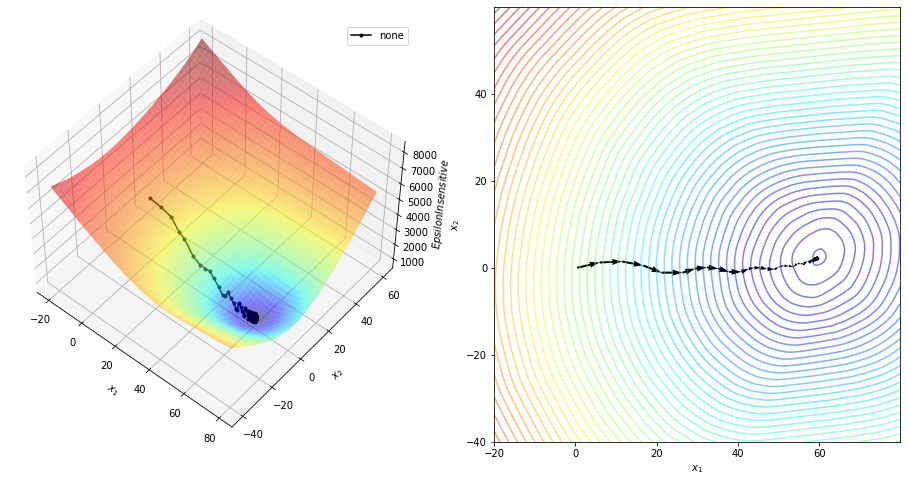

In [62]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
eps_loss_opt = plot_trajectory_optimization(eps_loss, grid.best_estimator_.optimizer, 
                                            color='k', label='none')

In [63]:
none_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_eps_cv_results.insert(1, 'momentum', 'none')
none_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.305684  0.476051      61   100
                    0.2      0.271255  0.476051      61   100
                    0.3      0.295661  0.476051      61   100
                10  0.1      0.271766  0.976336      65    99
                    0.2      0.302971  0.976335      65    97
                    0.3      0.312793  0.976335      65    96
                100 0.1      0.217348  0.977543      29    99
                    0.2      0.196685  0.977543      28    98
                    0.3      0.086447  0.977543      32    96

Fitting 1 folds for each of 9 candidates, totalling 9 fits


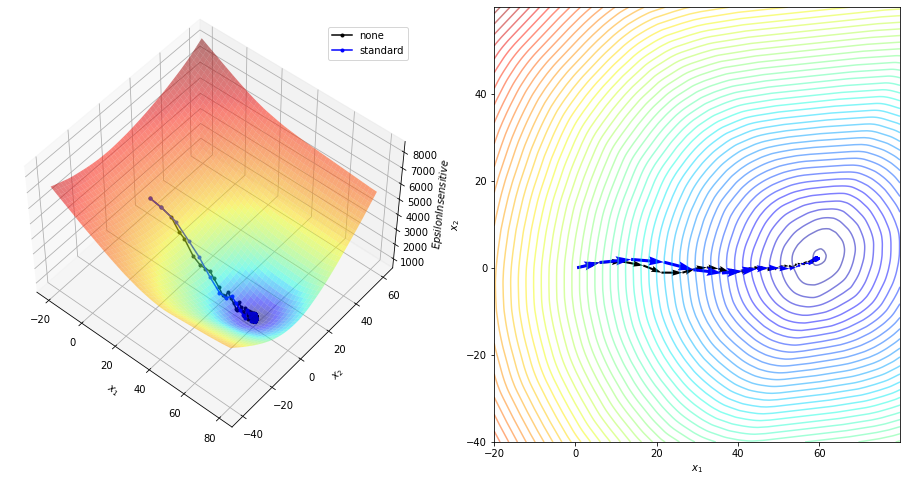

In [64]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='b', label='standard')
eps_loss_opt

In [65]:
standard_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_eps_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
standard_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    standard 1   0.1      0.090969  0.496182      39   100
                    0.2      0.081605  0.496182      39   100
                    0.3      0.082573  0.496182      39   100
                10  0.1      0.086846  0.976716      41   100
                    0.2      0.078833  0.976717      41   100
                    0.3      0.087009  0.976717      41    98
                100 0.1      0.030361  0.977554      11    98
                    0.2      0.037782  0.977554      11    97
                    0.3      0.025428  0.977554      11    97

Fitting 1 folds for each of 9 candidates, totalling 9 fits


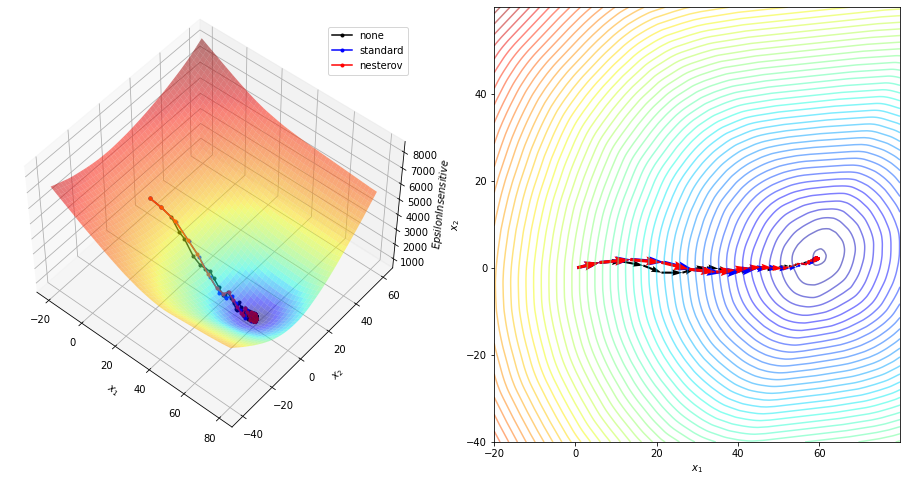

In [66]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='r', label='nesterov')
eps_loss_opt.savefig('./tex/img/svr_eps_loss.png')
eps_loss_opt

In [67]:
nesterov_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_eps_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      0.069402  0.495933      39   100
                    0.2      0.085645  0.495933      39   100
                    0.3      0.081845  0.495933      39   100
                10  0.1      0.083945  0.976679      41   100
                    0.2      0.086326  0.976678      41   100
                    0.3      0.083877  0.976679      41    98
                100 0.1      0.026455  0.977550      12    99
                    0.2      0.034582  0.977550      12    97
                    0.3      0.023644  0.977550      11    97

In [68]:
custom_primal_svr_eps_cv_results = none_primal_svr_eps_cv_results.append(
    standard_primal_svr_eps_cv_results).append(
    nesterov_primal_svr_eps_cv_results)
custom_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.305684  0.476051      61   100
                    0.2      0.271255  0.476051      61   100
                    0.3      0.295661  0.476051      61   100
                10  0.1      0.271766  0.976336      65    99
                    0.2      0.302971  0.976335      65    97
                    0.3      0.312793  0.976335      65    96
                100 0.1      0.217348  0.977543      29    99
                    0.2      0.196685  0.977543      28    98
                    0.3      0.086447  0.977543      32    96
       standard 1   0.1      0.090969  0.496182      39   100
                    0.2      0.081605  0.496182      39   100
                    0.3      0.082573  0.496182      39   100
                10  0.1      0.086846  0.976716      41   100
                    0.2      0.078833  0.976717      41   100
                    0.3      0.087009  0.976717      41    98
                100 0.1      0.030361  0.977554      11    98
                    0.2      0.037782  0.977554      11    97
                    0.3      0.025428  0.977554      11    97
       nesterov 1   0.1      0.069402  0.495933      39   100
                    0.2      0.085645  0.495933      39   100
                    0.3      0.081845  0.495933      39   100
                10  0.1      0.083945  0.976679      41   100
                    0.2      0.086326  0.976678      41   100
                    0.3      0.083877  0.976679      41    98
                100 0.1      0.026455  0.977550      12    99
                    0.2      0.034582  0.977550      12    97
                    0.3      0.023644  0.977550      11    97

In [69]:
grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive', random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [70]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.000879  0.964163      12    97
                       0.2      0.000794  0.963786      12    97
                       0.3      0.001147  0.963443      18    95
                   10  0.1      0.001303  0.977559     111   100
                       0.2      0.001115  0.977552     126    99
                       0.3      0.001408  0.977564     253    98
                   100 0.1      0.001333  0.977481     672    99
                       0.2      0.001883  0.977442     881    99
                       0.3      0.001565  0.977458    1000    98

In [71]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='H')
primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      0.305684  0.476051      61   100
                       0.2      0.271255  0.476051      61   100
                       0.3      0.295661  0.476051      61   100
                   10  0.1      0.271766  0.976336      65    99
                       0.2      0.302971  0.976335      65    97
                       0.3      0.312793  0.976335      65    96
                   100 0.1      0.217348  0.977543      29    99
                       0.2      0.196685  0.977543      28    98
                       0.3      0.086447  0.977543      32    96
          standard 1   0.1      0.090969  0.496182      39   100
                       0.2      0.081605  0.496182      39   100
                       0.3      0.082573  0.496182      39   100
                   10  0.1      0.086846  0.976716      41   100
                       0.2      0.078833  0.976717      41   100
                       0.3      0.087009  0.976717      41    98
                   100 0.1      0.030361  0.977554      11    98
                       0.2      0.037782  0.977554      11    97
                       0.3      0.025428  0.977554      11    97
          nesterov 1   0.1      0.069402  0.495933      39   100
                       0.2      0.085645  0.495933      39   100
                       0.3      0.081845  0.495933      39   100
                   10  0.1      0.083945  0.976679      41   100
                       0.2      0.086326  0.976678      41   100
                       0.3      0.083877  0.976679      41    98
                   100 0.1      0.026455  0.977550      12    99
                       0.2      0.034582  0.977550      12    97
                       0.3      0.023644  0.977550      11    97
liblinear -        1   0.1      0.000879  0.964163      12    97
                       0.2      0.000794  0.963786      12    97
                       0.3      0.001147  0.963443      18    95
                   10  0.1      0.001303  0.977559     111   100
                       0.2      0.001115  0.977552     126    99
                       0.3      0.001408  0.977564     253    98
                   100 0.1      0.001333  0.977481     672    99
                       0.2      0.001883  0.977442     881    99
                       0.3      0.001565  0.977458    1000    98

### Dual formulations

In [83]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [84]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [85]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0: -1.0397e+04 -2.9962e+04  7e+04  1e+00  7e-16
 1: -6.7462e+03 -1.6638e+04  1e+04  5e-14  5e-16
 2: -8.3626e+03 -9.5795e+03  1e+03  1e-13  4e-16
 3: -8.9398e+03 -9.1780e+03  2e+02  1e-13  4e-16
 4: -9.0354e+03 -9.1031e+03  7e+01  7e-14  3e-16
 5: -9.0662e+03 -9.0757e+03  9e+00  2e-13  4e-16
 6: -9.0712e+03 -9.0713e+03  1e-01  2e-13  5e-16
 7: -9.0712e+03 -9.0712e+03  1e-03  1e-13  3e-16
Optimal solution found.


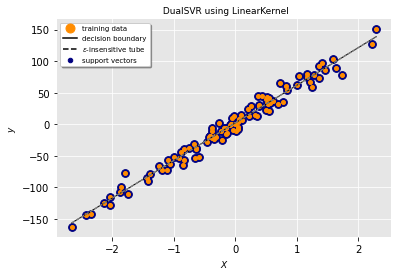

In [86]:
grid = GridSearchCV(DualSVR(kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [87]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
cvxopt 1   0.1      0.044434  0.964127      10   100
           0.2      0.040610  0.963709       9   100
           0.3      0.050188  0.963706       9   100
       10  0.1      0.043882  0.977576       8   100
           0.2      0.059017  0.977573       9   100
           0.3      0.037176  0.977573       9    99
       100 0.1      0.057136  0.977515       8   100
           0.2      0.045696  0.977496       9   100
           0.3      0.033306  0.977493       9   100
smo    1   0.1      0.023381  0.964127      17    98
           0.2      0.044661  0.963707      18    96
           0.3      0.035539  0.963707      14    96
       10  0.1      0.137995  0.977576      69   100
           0.2      0.500972  0.977573     749   100
           0.3      0.129166  0.977573      78    99
       100 0.1      0.544417  0.977515     549   100
           0.2      0.471177  0.977496     723   100
           0.3      0.512489  0.977493     926    99

In [88]:
grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[LibSVM]

In [89]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
libsvm 1   0.1      0.003990  0.964103      81    98
           0.2      0.005355  0.963680      81    97
           0.3      0.007024  0.963684      78    96
       10  0.1      0.009187  0.977559     226   100
           0.2      0.005927  0.977554     706   100
           0.3      0.011225  0.977564     181    99
       100 0.1      0.008480  0.977481    1224   100
           0.2      0.017160  0.977450    2126   100
           0.3      0.008723  0.977463    2680    99

In [90]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], ascending=[False, True, True], inplace=True)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='H')
linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
smo    1   0.1      0.023381  0.964127      17    98
           0.2      0.044661  0.963707      18    96
           0.3      0.035539  0.963707      14    96
       10  0.1      0.137995  0.977576      69   100
           0.2      0.500972  0.977573     749   100
           0.3      0.129166  0.977573      78    99
       100 0.1      0.544417  0.977515     549   100
           0.2      0.471177  0.977496     723   100
           0.3      0.512489  0.977493     926    99
libsvm 1   0.1      0.003990  0.964103      81    98
           0.2      0.005355  0.963680      81    97
           0.3      0.007024  0.963684      78    96
       10  0.1      0.009187  0.977559     226   100
           0.2      0.005927  0.977554     706   100
           0.3      0.011225  0.977564     181    99
       100 0.1      0.008480  0.977481    1224   100
           0.2      0.017160  0.977450    2126   100
           0.3      0.008723  0.977463    2680    99
cvxopt 1   0.1      0.044434  0.964127      10   100
           0.2      0.040610  0.963709       9   100
           0.3      0.050188  0.963706       9   100
       10  0.1      0.043882  0.977576       8   100
           0.2      0.059017  0.977573       9   100
           0.3      0.037176  0.977573       9    99
       100 0.1      0.057136  0.977515       8   100
           0.2      0.045696  0.977496       9   100
           0.3      0.033306  0.977493       9   100

##### Nonlinear

In [ ]:
grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

Fitting 1 folds for each of 18 candidates, totalling 18 fits


In [ ]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

In [ ]:
grid = GridSearchCV(DualSVR(),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [ ]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

In [ ]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

In [ ]:
grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

In [ ]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

In [ ]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='H')
nonlinear_dual_svr_cv_results

#### Lagrangian Dual

##### Linear

In [ ]:
grid = GridSearchCV(DualSVR(kernel=linear, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

In [ ]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], ascending=[False, True], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='H')
linear_lagrangian_dual_svr_cv_results

##### Nonlinear

In [ ]:
grid = GridSearchCV(DualSVR(optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

In [ ]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='H')
nonlinear_lagrangian_dual_svr_cv_results

## Squared Epsilon-insensitive loss

### Primal formulation

In [31]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [72]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits


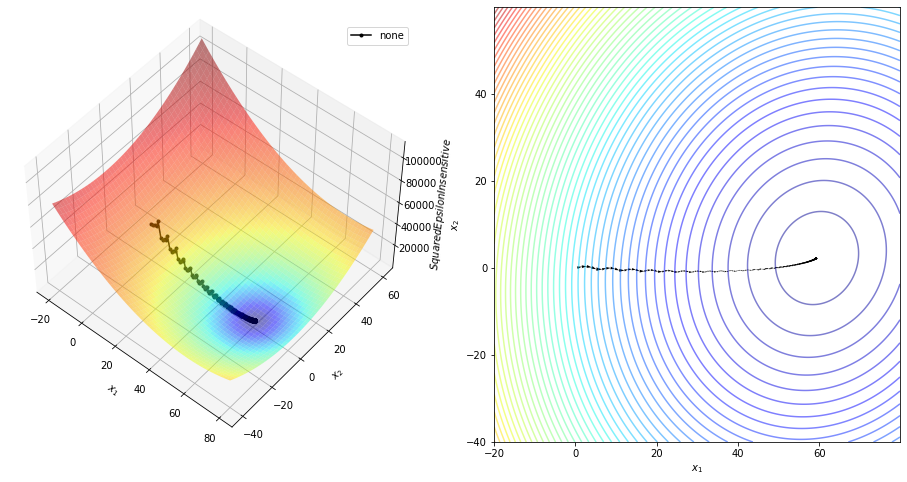

In [73]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='none', learning_rate=0.001, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss, grid.best_estimator_.optimizer, 
                                                    color='k', label='none')

In [74]:
none_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'none')
none_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      1.203146  0.977025     641   100
                    0.2      1.090908  0.977021     633    99
                    0.3      1.121058  0.977016     625    99
                10  0.1      0.423047  0.977573      74   100
                    0.2      0.342571  0.977572      70    99
                    0.3      0.355486  0.977572      72    99
                100 0.1      0.111561  0.977409       9   100
                    0.2      0.101309  0.977408       9    99
                    0.3      0.039628  0.977407       9    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits


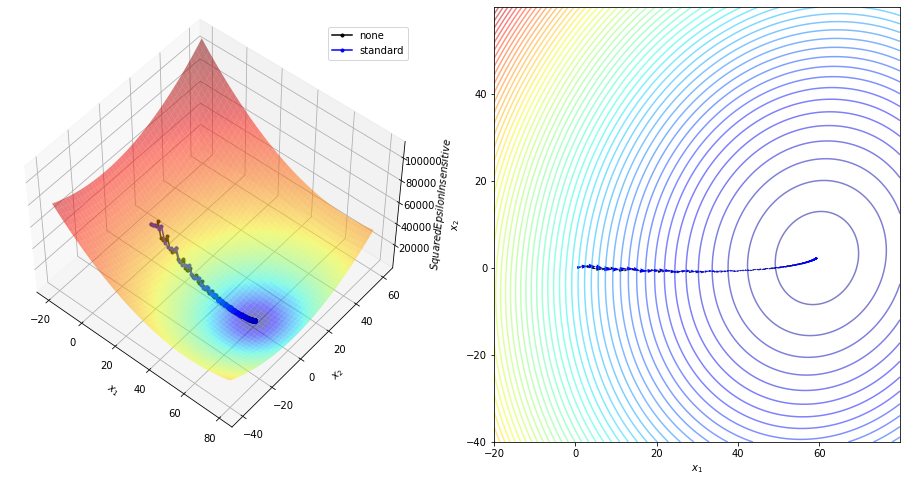

In [75]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='standard', momentum=0.4, learning_rate=0.001, batch_size=20, 
                              early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='b', label='standard')
squared_eps_loss_opt

In [76]:
standard_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
standard_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    standard 1   0.1      0.710437  0.977035     398   100
                    0.2      0.586380  0.977031     392    99
                    0.3      0.694706  0.977025     385    99
                10  0.1      0.097984  0.977572      42    99
                    0.2      0.159697  0.977571      40    99
                    0.3      0.151594  0.977572      42    99
                100 0.1      0.017708  0.977439       7    99
                    0.2      0.022605  0.977438       7    99
                    0.3      0.033693  0.977441       7    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits


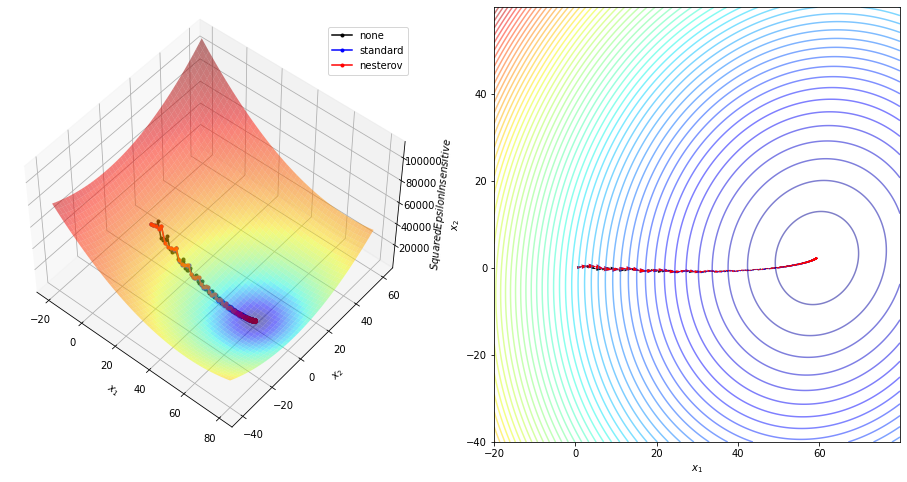

In [77]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='nesterov', momentum=0.4, learning_rate=0.001, batch_size=20, 
                              early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='r', label='nesterov')
squared_eps_loss_opt.savefig('./tex/img/svr_squared_eps_loss.png')
squared_eps_loss_opt

In [78]:
nesterov_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      0.528662  0.977035     399   100
                    0.2      0.499102  0.977030     392    99
                    0.3      0.507848  0.977026     386    99
                10  0.1      0.086664  0.977572      43    99
                    0.2      0.070886  0.977572      42    99
                    0.3      0.086196  0.977570      40    99
                100 0.1      0.016199  0.977411       7   100
                    0.2      0.018226  0.977411       7    99
                    0.3      0.016476  0.977413       7    98

In [79]:
custom_primal_svr_squared_eps_cv_results = none_primal_svr_squared_eps_cv_results.append(
    standard_primal_svr_squared_eps_cv_results).append(
    nesterov_primal_svr_squared_eps_cv_results)
custom_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      1.203146  0.977025     641   100
                    0.2      1.090908  0.977021     633    99
                    0.3      1.121058  0.977016     625    99
                10  0.1      0.423047  0.977573      74   100
                    0.2      0.342571  0.977572      70    99
                    0.3      0.355486  0.977572      72    99
                100 0.1      0.111561  0.977409       9   100
                    0.2      0.101309  0.977408       9    99
                    0.3      0.039628  0.977407       9    98
       standard 1   0.1      0.710437  0.977035     398   100
                    0.2      0.586380  0.977031     392    99
                    0.3      0.694706  0.977025     385    99
                10  0.1      0.097984  0.977572      42    99
                    0.2      0.159697  0.977571      40    99
                    0.3      0.151594  0.977572      42    99
                100 0.1      0.017708  0.977439       7    99
                    0.2      0.022605  0.977438       7    99
                    0.3      0.033693  0.977441       7    98
       nesterov 1   0.1      0.528662  0.977035     399   100
                    0.2      0.499102  0.977030     392    99
                    0.3      0.507848  0.977026     386    99
                10  0.1      0.086664  0.977572      43    99
                    0.2      0.070886  0.977572      42    99
                    0.3      0.086196  0.977570      40    99
                100 0.1      0.016199  0.977411       7   100
                    0.2      0.018226  0.977411       7    99
                    0.3      0.016476  0.977413       7    98

In [80]:
grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive', random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [81]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.001553  0.977554      96   100
                       0.2      0.001414  0.977553      96   100
                       0.3      0.001962  0.977551      96   100
                   10  0.1      0.006422  0.977577     826   100
                       0.2      0.007993  0.977576     826    99
                       0.3      0.005684  0.977576     839    99
                   100 0.1      0.008910  0.977538    1000   100
                       0.2      0.008264  0.977540    1000    99
                       0.3      0.007509  0.977541    1000    98

In [82]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='H')
primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      1.203146  0.977025     641   100
                       0.2      1.090908  0.977021     633    99
                       0.3      1.121058  0.977016     625    99
                   10  0.1      0.423047  0.977573      74   100
                       0.2      0.342571  0.977572      70    99
                       0.3      0.355486  0.977572      72    99
                   100 0.1      0.111561  0.977409       9   100
                       0.2      0.101309  0.977408       9    99
                       0.3      0.039628  0.977407       9    98
          standard 1   0.1      0.710437  0.977035     398   100
                       0.2      0.586380  0.977031     392    99
                       0.3      0.694706  0.977025     385    99
                   10  0.1      0.097984  0.977572      42    99
                       0.2      0.159697  0.977571      40    99
                       0.3      0.151594  0.977572      42    99
                   100 0.1      0.017708  0.977439       7    99
                       0.2      0.022605  0.977438       7    99
                       0.3      0.033693  0.977441       7    98
          nesterov 1   0.1      0.528662  0.977035     399   100
                       0.2      0.499102  0.977030     392    99
                       0.3      0.507848  0.977026     386    99
                   10  0.1      0.086664  0.977572      43    99
                       0.2      0.070886  0.977572      42    99
                       0.3      0.086196  0.977570      40    99
                   100 0.1      0.016199  0.977411       7   100
                       0.2      0.018226  0.977411       7    99
                       0.3      0.016476  0.977413       7    98
liblinear -        1   0.1      0.001553  0.977554      96   100
                       0.2      0.001414  0.977553      96   100
                       0.3      0.001962  0.977551      96   100
                   10  0.1      0.006422  0.977577     826   100
                       0.2      0.007993  0.977576     826    99
                       0.3      0.005684  0.977576     839    99
                   100 0.1      0.008910  0.977538    1000   100
                       0.2      0.008264  0.977540    1000    99
                       0.3      0.007509  0.977541    1000    98